# Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import pickle
#from numba import cuda
from scipy import spatial, sparse
import random as rd

In [2]:
data = pd.read_csv('~/fires_merged_weather.csv', index_col=0,
                  #dtype for smaller representation
                  dtype={'STAT_CAUSE_DESCR': 'category', 'STATE': 'category', 'DISCOVERY_MONTH': 'category',
                        'Fog': 'bool', 'FunnelCloud': 'bool', 'Hail': 'bool', 'Rain': 'bool',
                        'Snow': 'bool', 'Thunder': 'bool'}
                  )

making doy relative to year, equal to days since 1/1/1992 now

In [3]:
data['DAY'] = (data['FIRE_YEAR']-1992)*365+data['DISCOVERY_DOY']

In [4]:
#data = data[data['FIRE_YEAR']==2015]
data.reset_index(drop=True,inplace=True)

## Sort data by day

In [5]:
%%time

data = data.sort_values('DAY', ascending=True, kind='mergesort')

CPU times: user 565 ms, sys: 116 ms, total: 681 ms
Wall time: 698 ms


#### make a dict to keep track of the new vs old ordering

In [6]:
data

,Unnamed: 0.1,index_x,FOD_ID,FIRE_NAME,STAT_CAUSE_DESCR,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,...,Unnamed: 0.1.1.1,Visibility,WBAN,Windspeed,Year,doy,x,y,z,DAY
7351,7351,49226,49564,CITY,Lightning,1992,1,0.10,38.205000,-120.335000,...,444648.0,38.3,99999.0,1.6,1992.0,34.887671,-2478.130105,-4292.247250,3996.770412,1
11464,11464,174264,176266,BRADLEY,Debris Burning,1992,1,10.00,35.483400,-83.183200,...,284556.0,12.0,3812.0,2.8,1992.0,34.887671,673.739912,-5143.923069,3691.181246,1
12128,12128,181060,183204,FIRST FIRE,Equipment Use,1992,1,0.10,43.325000,-101.018500,...,433811.0,17.5,24032.0,2.0,1992.0,34.887671,-854.271186,-4586.892084,4332.358567,1
13251,13251,191959,194413,VOLCAN 1-5,Debris Burning,1992,1,5.00,33.166700,-116.634200,...,269023.0,42.5,99999.0,0.9,1992.0,34.887671,-2426.057969,-4768.194049,3452.138069,1
20000,20000,245383,250183,A 5,Miscellaneous,1992,1,20.00,25.882760,-80.959320,...,200216.0,8.4,99999.0,8.5,1992.0,34.887671,953.920400,-5659.738436,2756.099727,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1873795,67821,1856832,300289975,155240,Missing/Undefined,2015,365,0.10,33.421270,-111.954210,...,633830.0,10.0,23183.0,3.0,2015.0,12734.000000,-1990.914567,-4926.696177,3507.508085,8760
1879220,73246,1871977,300308335,ACADEMY 2,Debris Burning,2015,365,0.10,36.536611,-119.556721,...,718899.0,3.0,53119.0,1.4,2015.0,12734.000000,-2536.226147,-4459.308573,3771.049321,8760
1879228,73254,1871985,300308343,LEIGH,Missing/Undefined,2015,365,0.10,32.701123,-117.007382,...,645412.0,8.0,53143.0,1.5,2015.0,12734.000000,-2426.748558,-4768.315811,3451.484429,8760
1879528,73554,1872285,300308657,NaN,Missing/Undefined,2015,365,0.01,35.050000,-120.166666,...,721087.0,10.0,23273.0,2.9,2015.0,12734.000000,-2646.344348,-4501.759462,3642.761636,8760


In [7]:
order_dict = dict(zip(range(data.shape[0]),data.index))

# Using both
Threshold: only if edge meets **both** criteria

In [8]:
def get_block(values, dist, row_start, row_end, col_start, col_end):
    
    N = values.shape[0]

    # Get the relevant values for this block
    #print("Get row/col vals")
    row_values = values[row_start:row_end, :]
    col_values = values[col_start:col_end, :]

    # Get distance matrix for this block
    #print("Calculate distance")
    # use cuda implementation from stackoverflow
    D = spatial.distance.cdist(row_values, col_values)

    # Threshold it
    #print("Threshold it")
    subA = D <= dist
    
    return subA

def get_A_both(data_space, dist_space, data_time, dist_time, blocksize=10000, ordering=None):
    
    print("Setting up...")
    space_values = np.array(data_space.values)
    time_values = np.array(data_time.values)
    
    # Dimensions should be be (N, K), even if K = 1 columns. Reshape if needed
    if len(space_values.shape) == 1:
        space_values = space_values.reshape((space_values.shape[0], 1))
    if len(time_values.shape) == 1:
        time_values = time_values.reshape((time_values.shape[0], 1))
        
    assert space_values.shape[0] == time_values.shape[0], "Datasets must have same number of observations"
    N = space_values.shape[0]
        
    print("Initializing sparse matrix...")
    # Initialize sparse matrix
    A = sparse.lil_matrix((N,N))
    
    # Divide-and-conquer: split the overall big adjacency matrix into
    # blocksize x blocksize chunks, then use scipy's super-fast C implementation for distance matrix
    for i in range(N // blocksize+1):
        skip_row = False
            
        for j in range(i, N // blocksize+1):
            
            if skip_row:
                continue
            
            # Make sure we don't go out of bounds if N isn't divisible by blocksize!
            row_start = i * blocksize
            row_end   = min((i+1) * blocksize, N-1)
            col_start = j * blocksize
            col_end   = min((j+1) * blocksize, N-1)
            
            sub_A_time = get_block(time_values, dist_time, row_start, row_end, col_start, col_end)
            
            if (sub_A_time == 0).all():
                #print((i,j))
                #print("No more non-zeroes column-wise on this row!  Skipping to next")
                skip_row = True
                
            sub_A_space = get_block(space_values, dist_space, row_start, row_end, col_start, col_end)
            
            # Insert into matrix
            #print("Insert into matrix")
            subA = sub_A_time * sub_A_space            
            
            A[row_start:row_end, col_start:col_end] = subA
            
            # This graph is undirected--A will be symmetric! So set the other side now
            #if i != j:
                #print("Insert into matrix, transposed")
                #A[col_start:col_end, row_start:row_end] = subA.T

    # Convert to CSR format for fast arithmetic
    if ordering!=None:
        row = np.array(sparse.find(A)[0])
        row = [ordering[i] for i in row]
        col = np.array(sparse.find(A)[1])
        col = [ordering[i] for i in col]
        entries = np.array(sparse.find(A)[2])
        A = sparse.csr_matrix( (entries, (row,col)), shape=(A.shape[0],A.shape[1]) )
    else:
        A = A.tocsr()
    
    # This graph is undirected--so set the other side to be symmetric
    # Do this efficiently by adding the transpose, and then removing the elements equal to 2 to 1
    A += A.T
    A[A == 2] = 1
            
    return A

In [9]:
attr_time = data[["DAY"]]
attr_space = data[["LATITUDE", "LONGITUDE"]]

In [10]:
%%time
Aboth = get_A_both(attr_space, 1.0, attr_time, 1.01, blocksize=100)

Setting up...
Initializing sparse matrix...
CPU times: user 1min 24s, sys: 1.14 s, total: 1min 26s
Wall time: 1min 26s


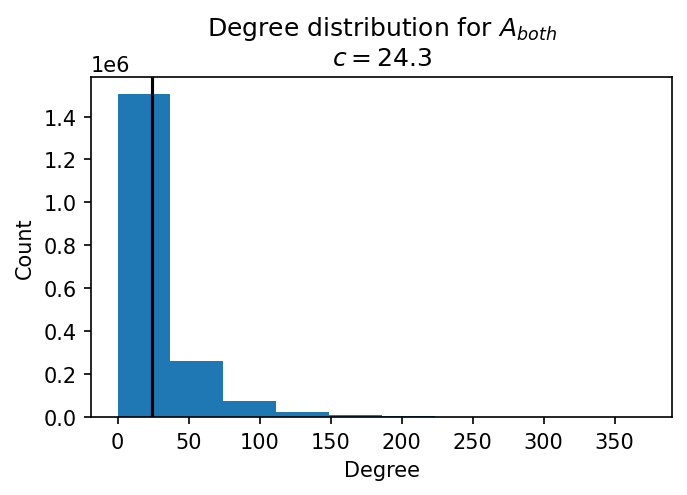

In [11]:
deg = Aboth.sum(axis=1)

fig, ax = plt.subplots(figsize=(5,3), dpi=150)
ax.hist(deg)
ax.set_ylabel("Count")
ax.set_xlabel("Degree")
ax.axvline(x=deg.mean(), ymin=0, ymax=1, color='black')
ax.set_title("Degree distribution for $A_{both}$" + "\n$c={0:.1f}$".format(deg.mean()))
plt.show()

# Save sparse matrices to disk

In [12]:
with open('A_BOTH_SORTED_FINAL.pkl', 'wb') as f:
    pickle.dump(Aboth, f)